In [27]:
import torch
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Product, ConstantKernel as C
import matplotlib.pyplot as plt

In [4]:
latent_dim = 2
num_proc = 6

posterior = torch.rand((num_proc, 2 * latent_dim))

In [5]:
posterior

tensor([[8.2759e-01, 1.2114e-01, 2.2203e-01, 6.1244e-01],
        [2.9089e-01, 3.1902e-01, 9.9600e-01, 2.1384e-01],
        [8.0842e-01, 5.1573e-01, 3.8194e-01, 9.7683e-01],
        [1.2689e-01, 1.4311e-01, 7.2004e-01, 1.6600e-01],
        [4.7110e-02, 6.4944e-01, 3.0490e-01, 7.8194e-01],
        [8.8066e-04, 9.6077e-01, 9.0394e-01, 5.2614e-01]])

In [168]:
kernel = C(1.0, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5))
alpha = 0.25
n_restart = 10

gp_list = [GaussianProcessRegressor(kernel=kernel, 
                              alpha=alpha ** 2,
                              normalize_y=True,
                              n_restarts_optimizer=n_restart)
          for _ in range(num_proc)
          ]

In [174]:
gp = gp_list[0]
x = np.arange(100)
y = np.arange(100)


x = np.atleast_2d(x).T
y = np.atleast_2d(y).T

In [175]:
gp.fit(x, y)

GaussianProcessRegressor(alpha=0.0625, copy_X_train=True,
                         kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [176]:
x = np.arange(50)
x = np.atleast_2d(x).T
y_pred, sigma = gp.predict(x, return_std=True)

(-10, 50)

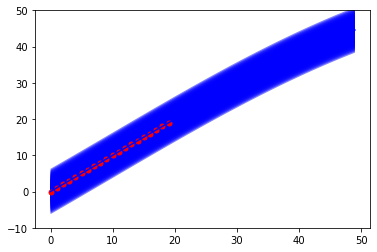

In [138]:
plt.figure()
plt.plot(x[0:20], y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.ylim(-10, 50)

In [145]:
y_pred[21]

array([20.93104583])

In [146]:
sigma[21]

0.21674038316479433

In [208]:
kernel = C(1.0, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5))
alpha = 0.25
n_restart = 1

gp_list = []
for i in range(latent_dim):
    gp_list.append([GaussianProcessRegressor(kernel=kernel, 
                              alpha=alpha ** 2,
                              normalize_y=True,
                              n_restarts_optimizer=n_restart)
              for _ in range(num_proc)
              ])

In [215]:
num_task = 30
sw_size = 10
posterior_history = torch.empty(num_task, num_proc, 2 * latent_dim)
for t in range(num_task):
    posterior = t * torch.ones((num_proc, 2 * latent_dim))
    posterior_history[t, :, :] = posterior
    x = np.arange(t+1)
    x = np.atleast_2d(x).T
    for dim in range(latent_dim):
        for proc in range(num_proc):
            if t > sw_size:
                gp_list[dim][proc].fit(x[-sw_size:], np.atleast_2d(posterior_history[t+1-sw_size:t+1, proc, dim].numpy()).T)
            else:
                gp_list[dim][proc].fit(x, np.atleast_2d(posterior_history[0:t+1, proc, dim].numpy()).T)

[tensor([[14.9892,  0.0387],
         [14.9892,  0.0387]]), tensor([[14.9892,  0.0387],
         [14.9892,  0.0387]]), tensor([[14.9892,  0.0387],
         [14.9892,  0.0387]]), tensor([[14.9892,  0.0387],
         [14.9892,  0.0387]]), tensor([[14.9892,  0.0387],
         [14.9892,  0.0387]]), tensor([[14.9892,  0.0387],
         [14.9892,  0.0387]])]